### Software Requirements

- **pandas:** Required for data manipulation.
- **numpy:** Essential for numerical operations.
- **os:** For interacting with the operating system.
- **glob:** Helps in file manipulation.
- **matplotlib:** Used for data visualization.
- **seaborn:** Enhances data visualization.
- **datetime:** For working with date and time.
- **scikit-learn:** For machine learning models and evaluation.
    - **sklearn.tree.DecisionTreeClassifier:** For Decision Tree based classification.
    - **sklearn.ensemble.RandomForestClassifier:** For Random Forest based classification.
- **imblearn.over_sampling.SMOTE:** For synthetic oversampling in imbalanced datasets.
- **scipy:** Provides signal processing capabilities.
- **selenium,ChromeDriver/SafariDriver:** For web scraping and automation.

# Predicting a Geomagnetic Storm / Auroral activity

#### Capstone Project

#### Import all the python libraries

In [1]:
import warnings
# Set to ignore any warnings
warnings.filterwarnings('ignore')

In [2]:
#import libraries
import pandas as pd
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.model_selection import train_test_split,GridSearchCV
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#### Read the solar wind data at 1~au 

In [3]:
### read the csv file from the Data_collection folder
df = pd.read_csv('../Data_collection/Data/1992-2023.csv1', skiprows=None)

In [4]:
### Name the columns 
df.columns = ['date','B','T[K]','Np','Ur']

In [5]:
### Convert the date column to a datetime index
df['date'] = pd.to_datetime(df['date'])

In [6]:
df.set_index(df['date'],inplace = True)

In [7]:
sw = df.drop(columns = ['date'])

In [8]:
sw.head(3)

,B,T[K],Np,Ur
date,,,,
1992-01-01 00:30:00+00:00,999.9,10000000.0,999.9,9999.0
1992-01-01 01:30:00+00:00,999.9,10000000.0,999.9,9999.0
1992-01-01 02:30:00+00:00,999.9,10000000.0,999.9,9999.0


In [9]:
### Display the data into 3hours period which means we divide a single day into 8 divisons
sw  = sw.resample('3H').mean()

In [10]:
sw.head(8)

,B,T[K],Np,Ur
date,,,,
1992-01-01 00:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 03:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 06:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 09:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 12:00:00+00:00,10.833333,10000000.0,999.9,9999.0
1992-01-01 15:00:00+00:00,340.100000,10000000.0,999.9,9999.0
1992-01-01 18:00:00+00:00,999.900000,10000000.0,999.9,9999.0
1992-01-01 21:00:00+00:00,999.900000,10000000.0,999.9,9999.0


#### Check for nulls

In [11]:
sw.isna().sum()

B       0
T[K]    0
Np      0
Ur      0
dtype: int64

#### Check for unique values

In [12]:
### Minimum solar wind speed observed
np.min(sw['Ur'].unique())

237.33333333333334

In [13]:
### Maximum solar wind speed observed
np.max(sw['Ur'].unique())

9999.0

### Use the standard values for solar wind speed to categorize the solar wind speed 

In [14]:
### Categorize the wind speed into slow, and fast solar wind speed
sw.loc[(sw['Ur'] > 200.0) & (sw['Ur'] < 450.0), 'Wind_Category'] = 'slow'
sw.loc[(sw['Ur'] >=450) & (sw['Ur'] < 850.0), 'Wind_Category'] = 'fast'
sw.loc[sw['Ur'] >= 850, 'Wind_Category'] = 'extreme'

##### Pie chart for the solar wind distribution from year 1992 to 2022 december

In [15]:
sw['Wind_Category'].value_counts()

Wind_Category
slow       55891
fast       28129
extreme     6564
Name: count, dtype: int64

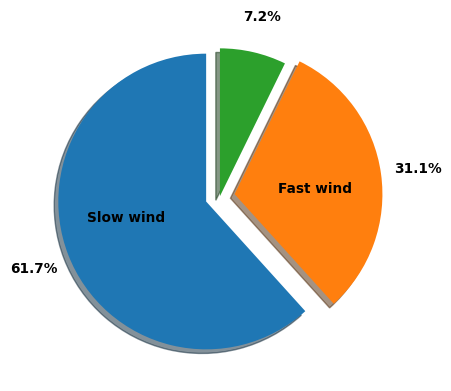

In [16]:
### Plot the pie chart for the solar wind speed distribution
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'Slow wind', 'Fast wind', '' ## add labels for the pie chart

ax.pie(sw['Wind_Category'].value_counts(dropna = False),explode = explode, 
       labels=labels,autopct='%1.1f%%',labeldistance=0.3,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})

plt.savefig("../images/pie_wind.png")
plt.show()


cite : https://www.w3schools.com/python/matplotlib_pie_charts.asp

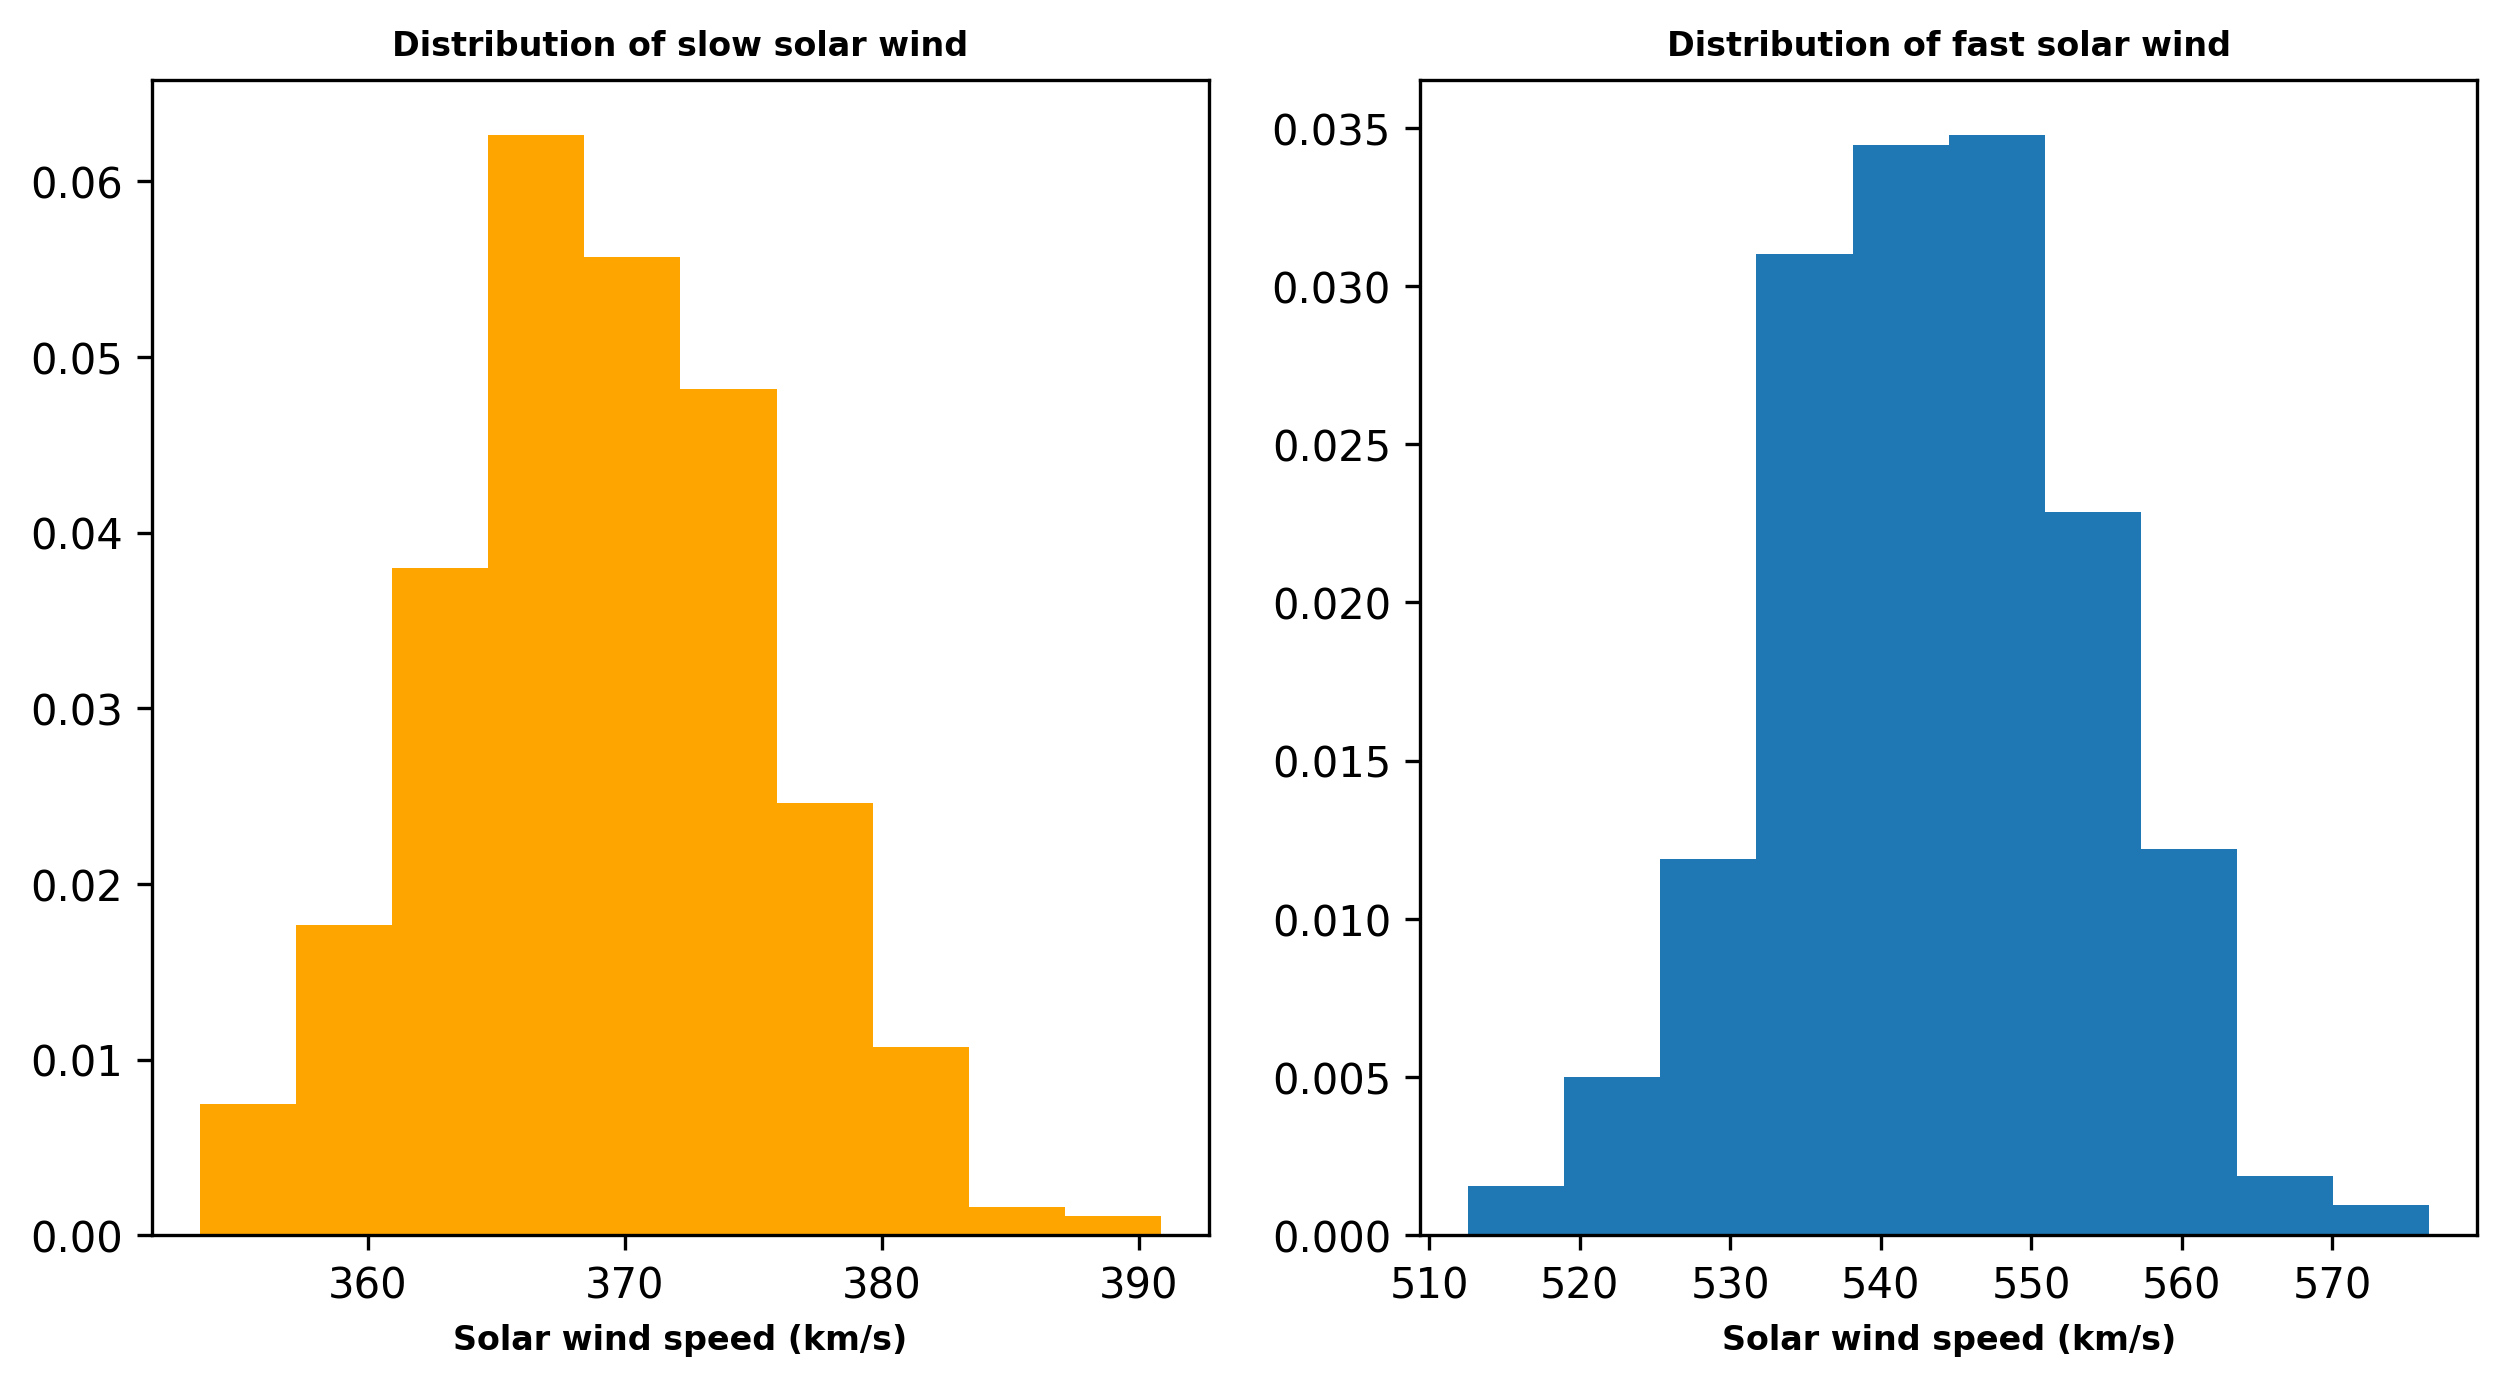

In [17]:
### Plot the distribution for the solar wind speed 

fig, (ax1, ax2) = plt.subplots(figsize=(10, 5), nrows = 1, ncols=2, dpi = 300)

xbars_1 = [np.mean(np.random.choice(sw['Ur'][sw['Wind_Category'] == 'slow'], size=50)) for _ in range(500)]
xbars_2 = [np.mean(np.random.choice(sw['Ur'][sw['Wind_Category'] == 'fast'], size=50)) for _ in range(500)]

ax1.hist(xbars_1,color='orange', density = True);
ax2.hist(xbars_2, density = True);
ax1.set_xlabel('Solar wind speed (km/s)',fontdict = {'weight': 'bold','size':8})
ax2.set_xlabel('Solar wind speed (km/s)',fontdict = {'weight': 'bold','size':8})
ax1.set_title('Distribution of slow solar wind',fontdict = {'weight': 'bold','size':8})
ax2.set_title('Distribution of fast solar wind',fontdict = {'weight': 'bold','size':8})

plt.savefig("../images/wind_distribution.png")
plt.show()


##### Pie chart for the solar wind density distribution from year 1992 to 2022 december

In [18]:
### Categorize the plasma density at 1au
sw.loc[(sw['Np'] >= 0.1) & (sw['Np'] < 7), 'Np_Category'] = 'low'
sw.loc[(sw['Np'] >= 7) & (sw['Np'] < 60), 'Np_Category'] = 'high'
sw.loc[sw['Np'] >= 60, 'Np_Category'] = 'extreme'

In [19]:
sw['Np_Category'].value_counts(dropna = False)

Np_Category
low        56975
high       25292
extreme     8317
Name: count, dtype: int64

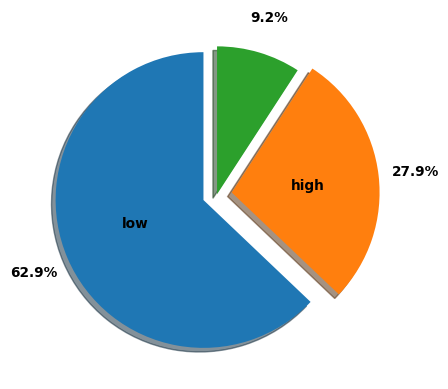

In [20]:
## Plot the pie chart for the solar wind density
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low', 'high', ''

ax.pie(sw['Np_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})


plt.savefig("../images/pie_np.png")
plt.show()


##### Pie chart for the solar wind magnetic field distribution from year 1992 to 2022 december

In [21]:
### Categorize the magnetic field at 1au
sw.loc[(sw['B'] >= 0.1) & (sw['B'] < 6.3), 'B_Category'] = 'low'
sw.loc[(sw['B'] >= 6.3) & (sw['B'] < 30), 'B_Category'] = 'high'
sw.loc[sw['B'] >= 30, 'B_Category'] = 'extreme'

In [22]:
sw['B_Category'].value_counts(dropna = False, normalize=True)

B_Category
low        0.642630
high       0.285326
extreme    0.072044
Name: proportion, dtype: float64

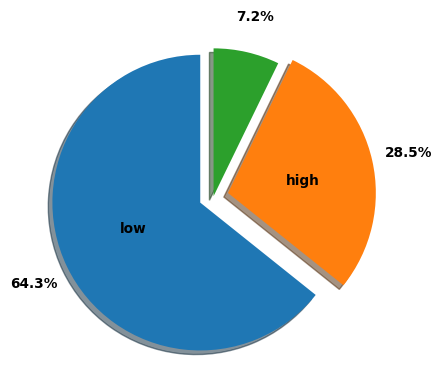

In [23]:
## Plot the pie chart for the magnetic field
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low', 'high', ''

ax.pie(sw['B_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})

plt.savefig("../images/pie_b.png")
plt.show()


##### Pie chart for the solar wind temperature at 1~au distribution from year 1992 to 2022 december

In [24]:
sw['T[K]'].describe()

count    9.058400e+04
mean     8.726592e+05
std      2.583303e+06
min      3.501667e+03
25%      3.930125e+04
50%      7.588567e+04
75%      1.528178e+05
max      1.000000e+07
Name: T[K], dtype: float64

In [25]:
### Categorize the magnetic field at 1au
sw.loc[(sw['T[K]'] >= 0) & (sw['T[K]'] < 110_000), 'T_Category'] = 'low'
sw.loc[(sw['T[K]'] >= 110_000) & (sw['T[K]'] < 1_000_000), 'T_Category'] = 'high'
sw.loc[sw['T[K]'] >= 1_000_000, 'T_Category'] = 'extreme'

In [26]:
sw['T_Category'].value_counts(dropna = False, normalize=True)

T_Category
low        0.642707
high       0.267520
extreme    0.089773
Name: proportion, dtype: float64

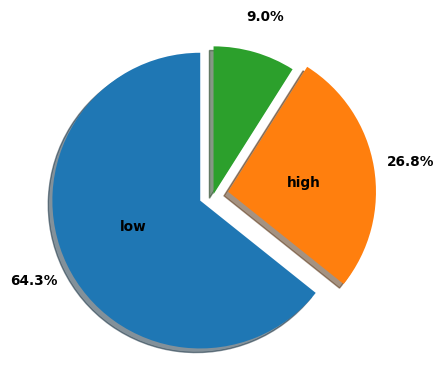

In [27]:
## Plot the piechart for the temperature
fig, ax = plt.subplots()

explode = (0.1, 0.1, 0)
labels = 'low', 'high', ''

ax.pie(sw['T_Category'].value_counts(dropna = False), labels = labels, explode = explode,
       autopct='%1.1f%%',labeldistance=0.4,pctdistance=1.25, shadow= True, startangle=90,
      textprops={'size': 9.8,'fontweight' : 'bold'})

plt.savefig("../images/pie_t.png")
plt.show()


In [28]:
## Drop the continous varibale to only remain the categorical varibales
sw.drop(columns = ['B','T[K]','Np','Ur'],inplace = True)

In [29]:
sw.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 90584 entries, 1992-01-01 00:00:00+00:00 to 2022-12-31 21:00:00+00:00
Freq: 3H
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Wind_Category  90584 non-null  object
 1   Np_Category    90584 non-null  object
 2   B_Category     90584 non-null  object
 3   T_Category     90584 non-null  object
dtypes: object(4)
memory usage: 3.5+ MB


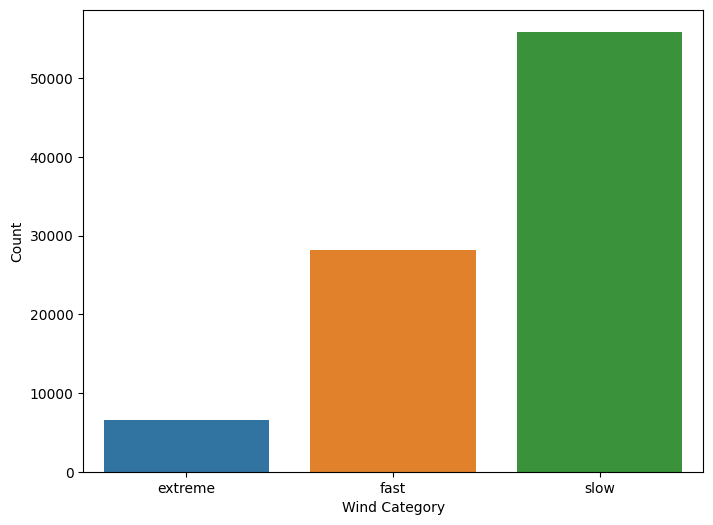

In [30]:
## Display the countplot / bar plot for the wind category to check the categorical values one more time

plt.figure(figsize=(8, 6))  
sns.countplot(data=sw, x='Wind_Category')  

plt.xlabel('Wind Category')
plt.ylabel('Count')

plt.savefig("../images/wind_counts.png")
plt.show()

#### Read the solar indicies and the geomagnatic indicies

In [31]:
## Read the all_param.csv file which includes the sunspot number and F10.7obs (radio flux) from the data collection folder
df2 = pd.read_csv('../Data_collection/Data/all_param.csv')

In [32]:
## Rename the columns for the dataframe as shown on the website for the data
df2.columns = ['YYY', 'MM', 'DD' , 'days' ,'days_m', 'Bsr','dB','Kp1', 'Kp2','Kp3','Kp4','Kp5','Kp6','Kp7','Kp8','ap1','ap2','ap3','ap4','ap5','ap6','ap7', 'ap8','Ap', 'SN', 'F10.7obs', 'F10.7adj' ,'D']

In [33]:
df2.head(3)

,YYY,MM,DD,days,days_m,Bsr,dB,Kp1,Kp2,Kp3,...,ap4,ap5,ap6,ap7,ap8,Ap,SN,F10.7obs,F10.7adj,D
0,1992,1,1,21915,21915.5,2164,1,2.667,2.000,2.667,...,9,9,22,7,15,12,186,248.5,240.3,2
1,1992,1,2,21916,21916.5,2164,2,4.667,4.333,3.667,...,48,9,15,7,6,22,190,260.2,251.6,2
2,1992,1,3,21917,21917.5,2164,3,3.000,3.000,2.333,...,22,15,9,22,22,16,234,279.6,270.4,2


In [34]:
df2.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11323 entries, 0 to 11322
Data columns (total 28 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   YYY       11323 non-null  int64  
 1   MM        11323 non-null  int64  
 2   DD        11323 non-null  int64  
 3   days      11323 non-null  int64  
 4   days_m    11323 non-null  float64
 5   Bsr       11323 non-null  int64  
 6   dB        11323 non-null  int64  
 7   Kp1       11323 non-null  float64
 8   Kp2       11323 non-null  float64
 9   Kp3       11323 non-null  float64
 10  Kp4       11323 non-null  float64
 11  Kp5       11323 non-null  float64
 12  Kp6       11323 non-null  float64
 13  Kp7       11323 non-null  float64
 14  Kp8       11323 non-null  float64
 15  ap1       11323 non-null  int64  
 16  ap2       11323 non-null  int64  
 17  ap3       11323 non-null  int64  
 18  ap4       11323 non-null  int64  
 19  ap5       11323 non-null  int64  
 20  ap6       11323 non-null  in

In [35]:
### Replacing -1 as nan
df2.replace({-1:np.nan},inplace = True)

In [36]:
### take the daily average of Kp values (8 values per day because values are given here for every 3hours) and store it in a new column
df2['Kp']= df2.loc[:,'Kp1' : 'Kp8'].mean(axis=1)

In [37]:
df2.head()

,YYY,MM,DD,days,days_m,Bsr,dB,Kp1,Kp2,Kp3,...,ap5,ap6,ap7,ap8,Ap,SN,F10.7obs,F10.7adj,D,Kp
0,1992,1,1,21915,21915.5,2164,1,2.667,2.000,2.667,...,9,22,7,15,12,186,248.5,240.3,2,2.583375
1,1992,1,2,21916,21916.5,2164,2,4.667,4.333,3.667,...,9,15,7,6,22,190,260.2,251.6,2,3.333375
2,1992,1,3,21917,21917.5,2164,3,3.000,3.000,2.333,...,15,9,22,22,16,234,279.6,270.4,2,3.083375
3,1992,1,4,21918,21918.5,2164,4,3.333,4.000,3.333,...,9,7,15,22,16,243,274.7,265.6,2,3.041625
4,1992,1,5,21919,21919.5,2164,5,3.333,3.000,2.333,...,9,18,15,7,12,242,266.5,257.7,2,2.708125


In [38]:
Kp_3hr = pd.DataFrame(df2.loc[:,'Kp1' : 'Kp8'].stack(), columns=['Kp'])

In [39]:
Kp_3hr.reset_index();

In [40]:
sw['Kp'] = Kp_3hr['Kp']

In [41]:
sw['Kp'] = np.array(Kp_3hr['Kp'])

In [42]:
### do the same for the ap data, but we didnt consider this for the modeling
ap_3hr = pd.DataFrame(df2.loc[:,'ap1' : 'ap8'].stack(), columns=['ap'])

In [43]:
sw['ap']= np.array(ap_3hr['ap'])

In [44]:
sw.head(6)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap
date,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22


In [45]:
## repeat the daily averages for Kp, ap, SN, F10.7obs, and F10.7adj 8 times for every 3hour for each single day

In [46]:
averages_kp = [sw['Kp'][i:i+8].mean() for i in range(0, len(sw['Kp']), 8)]

In [47]:
sw['Avg_Kp'] = np.repeat(averages_kp, 8)

In [48]:
averages_ap = [sw['ap'][i:i+8].mean() for i in range(0, len(sw['ap']), 8)]

In [49]:
sw['Avg_Ap'] = np.round(np.repeat(averages_ap, 8)).astype(int)

In [50]:
sw['SN'] = np.repeat(np.array(df2['SN']), 8)

In [51]:
sw['F10.7obs'] = np.repeat(np.array(df2['F10.7obs']), 8)

In [52]:
sw['F10.7adj'] = np.repeat(np.array(df2['F10.7adj']), 8)

In [53]:
sw.head(16)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj
date,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3
1992-01-01 18:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 21:00:00+00:00,extreme,extreme,extreme,extreme,3.000,15,2.583375,12,186,248.5,240.3
1992-01-02 00:00:00+00:00,extreme,extreme,extreme,extreme,4.667,39,3.333375,22,190,260.2,251.6


#### Check for the outliers of F10.7obs

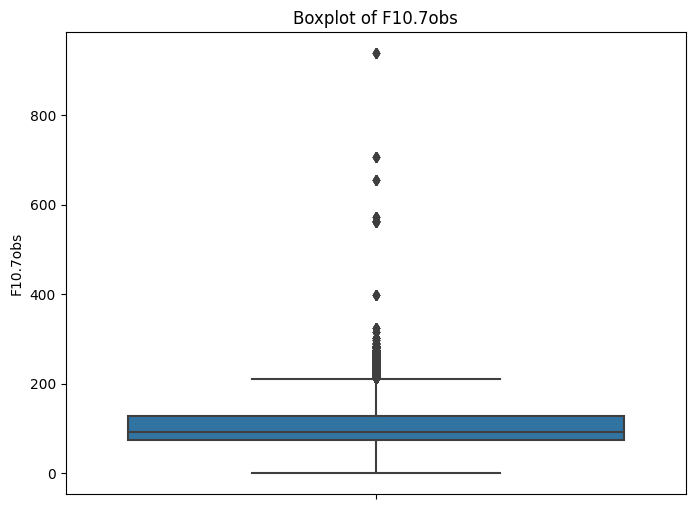

In [54]:
# Create a box plot using Seaborn
plt.figure(figsize=(8, 6))  # size of the plot

sns.boxplot(y=sw['F10.7obs'])
plt.title('Boxplot of F10.7obs')  # Set the title 
plt.savefig("../images/Boxplot_F10.7obs.png")
plt.show()

In [55]:
sw['F10.7obs'].describe()

count    90520.000000
mean       106.579072
std         42.788735
min          0.000000
25%         73.600000
50%         92.400000
75%        128.800000
max        938.600000
Name: F10.7obs, dtype: float64

In [56]:
### Remove the outliers and the nulls

In [57]:
#sw.loc[(sw['F10.7obs'] >= 250) | (sw['F10.7obs'] == 0), 'F10.7obs'] = np.nan

In [58]:
correlation = sw['SN'].corr(sw['F10.7obs'])
print(f"Pearson correlation coefficient: {np.round(correlation,3)}")

Pearson correlation coefficient: 0.89


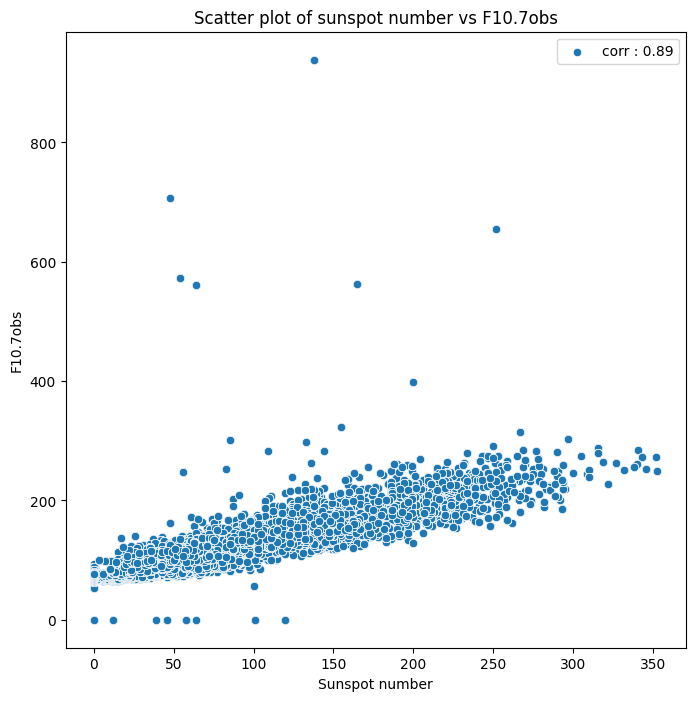

In [59]:
# Create a scatter plot using Seaborn
plt.figure(figsize=(8, 8))  # Define the size of the plot

sns.scatterplot(data=df, x=sw['SN'], y=sw['F10.7obs'],label = f"corr : {np.round(correlation,3)}")
plt.title('Scatter plot of sunspot number vs F10.7obs')  # Set the title 
plt.xlabel('Sunspot number')                             # Set the x-axis label
plt.ylabel('F10.7obs')                                   # Set the y-axis label

plt.legend()
plt.savefig("../images/sunspot_F10.7obs.png")
plt.show()

###### Didint remove the obsevered outliers and kept for training the model

#### Plot the sunspot solar cycle

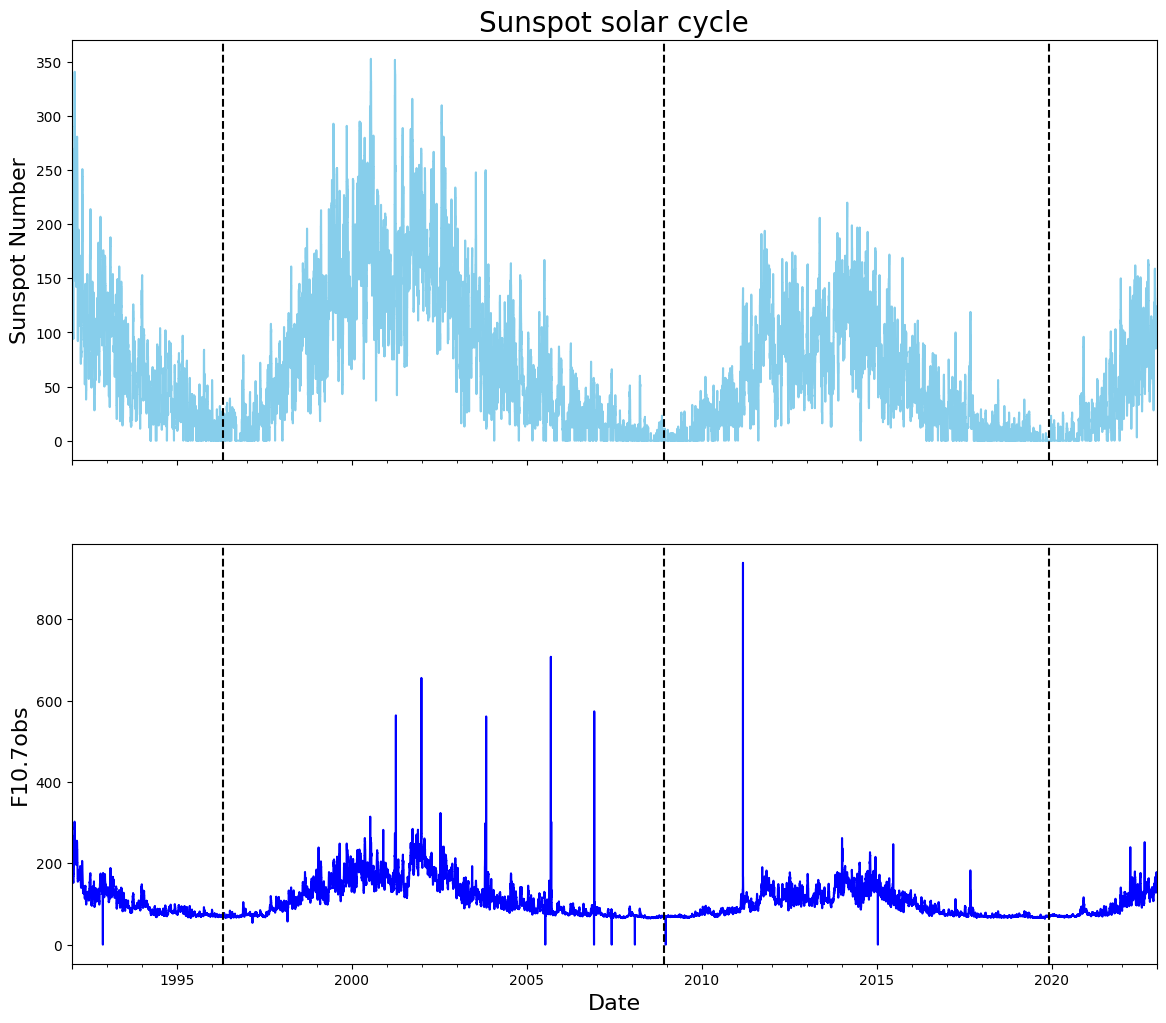

In [60]:
fig, (ax1, ax2) = plt.subplots(figsize=(14, 12), nrows=2, ncols=1,sharex=True) ## add size of the plot and the number of rows

sw['SN'].plot(ax=ax1,color = 'skyblue')
sw['F10.7obs'].plot(ax=ax2,color = 'blue')


ax1.set_ylabel("Sunspot Number",fontdict= {'size': 16})
ax1.set_title("Sunspot solar cycle",fontdict= {'size': 20})
ax2.set_xlabel("Date",fontdict= {'size': 16})
ax2.set_ylabel("F10.7obs",fontdict= {'size': 16})


# Add vertical lines at specific dates
ax1.axvline('1996-05', color='k', linestyle='--')
ax1.axvline('2008-12', color='k', linestyle='--')
ax1.axvline('2019-12', color='k', linestyle='--')

ax2.axvline('1996-05', color='k', linestyle='--')
ax2.axvline('2008-12', color='k', linestyle='--')
ax2.axvline('2019-12', color='k', linestyle='--')

plt.savefig("../images/sn_f10_timeseries.png")
plt.show()

In [61]:
sw.head(10)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj
date,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9,2.583375,12,186,248.5,240.3
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3
1992-01-01 18:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3
1992-01-01 21:00:00+00:00,extreme,extreme,extreme,extreme,3.000,15,2.583375,12,186,248.5,240.3
1992-01-02 00:00:00+00:00,extreme,extreme,extreme,extreme,4.667,39,3.333375,22,190,260.2,251.6


In [62]:
## Smooth the sunspot data
sw['smooth_sn'] = savgol_filter(sw['SN'],11951,1)

In [63]:
sw.head(10)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn
date,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.784625
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.772371
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.760116
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.747862
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.735607
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3,141.723353
1992-01-01 18:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.711098
1992-01-01 21:00:00+00:00,extreme,extreme,extreme,extreme,3.000,15,2.583375,12,186,248.5,240.3,141.698844
1992-01-02 00:00:00+00:00,extreme,extreme,extreme,extreme,4.667,39,3.333375,22,190,260.2,251.6,141.686589


#### Identify the trend of the sunspot solar cycle

In [64]:
### From the trend we can identify the phase of the solar cycle and use it as a catagerorical variable

## **Solar cycle phases:**

- Solar minimum
- Rising phase
- Solar maximum
- Declining phase

In [65]:
data = np.array(sw['smooth_sn'])

In [66]:
# Set the initial trend as declining (as from observed from the sunspot solar cycle plot)
trend = ['declining']

# Start the range from 1
for i in range(1, len(sw['smooth_sn'])):
    if sw['smooth_sn'].iloc[i] > sw['smooth_sn'].iloc[i - 1]:  
        trend.append('rising')
    else:
        trend.append('declining')

In [67]:
sw['phase']= trend

In [68]:
sw['phase'].value_counts(normalize=True)

phase
declining    0.54641
rising       0.45359
Name: proportion, dtype: float64

In [69]:
### Identifying the solar miniumn and maximum period from the time series plot and save it according to the phase

In [70]:
## Rename the data in the trend column as solar min for the period of '1995-06':'1997-02'
sw.loc['1995-06':'1997-02']['phase'].replace({'declining':'solar_min','rising':'solar_min'},inplace = True)

In [71]:
## Rename the data in the trend column as solar min for the period of '2008-02':'2009-11
sw.loc['2008-02':'2009-11']['phase'].replace({'declining':'solar_min','rising':'solar_min'},inplace = True)

In [72]:
sw.loc['2000-05':'2002-01']['phase'].replace({'declining':'solar_min','rising':'solar_max'},inplace = True)

In [73]:
sw.loc['2012-05':'2014-02']['phase'].replace({'declining':'solar_min','rising':'solar_max'},inplace = True)

In [74]:
sw['phase'].unique()

array(['declining', 'rising', 'solar_min', 'solar_max'], dtype=object)

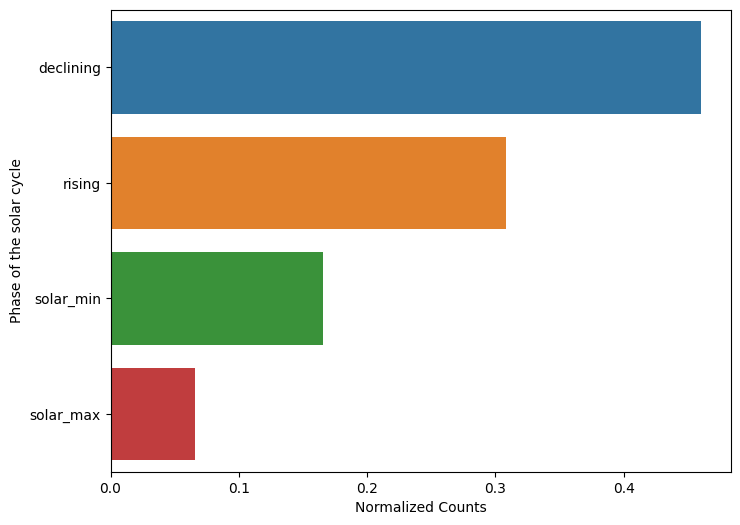

In [75]:
# Convert value counts to a DataFrame which display the counts of the each phase of the solar cycle
value_counts = sw['phase'].value_counts(normalize=True).reset_index()
value_counts.columns = ['Trend Categories', 'Normalized Counts']

plt.figure(figsize=(8, 6))  # the size of the plot

# Creating a horizontal bar plot using Seaborn
sns.barplot(data=value_counts, x='Normalized Counts', y='Trend Categories', orient='h')

plt.xlabel('Normalized Counts')
plt.ylabel('Phase of the solar cycle')

plt.savefig("../images/phase_count.png")
plt.show()

In [76]:
sw.head(6)

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn,phase
date,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.784625,declining
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.772371,declining
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.760116,declining
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.747862,declining
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.735607,declining
1992-01-01 15:00:00+00:00,extreme,extreme,extreme,extreme,3.667,22,2.583375,12,186,248.5,240.3,141.723353,declining


##### Adding a smooth line for the sunspot data

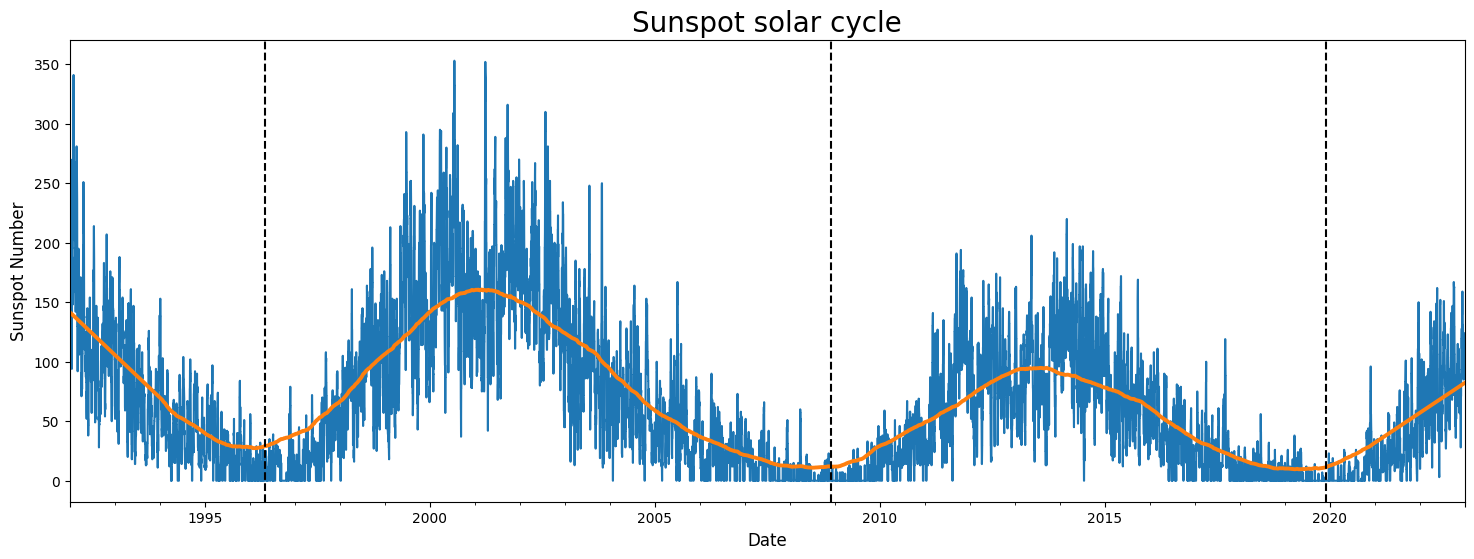

In [77]:
## Display the plot for sunspot number with the smoothed line
fig, ax = plt.subplots(figsize=(18, 6))  

sw['SN'].plot(ax=ax)
sw['smooth_sn'].plot(ax=ax,linewidth=2.8)

ax.set_xlabel("Date",fontdict= {'size': 12})
ax.set_ylabel("Sunspot Number",fontdict= {'size': 12})
ax.set_title("Sunspot solar cycle",fontdict= {'size': 20})

# Add vertical lines at specific dates
ax.axvline('1996-05', color='k', linestyle='--')
ax.axvline('2008-12', color='k', linestyle='--')
ax.axvline('2019-12', color='k', linestyle='--')

plt.savefig("../images/smoothed_solar.png")
plt.show()

In [78]:
## check for nulls
sw.isna().sum()

Wind_Category     0
Np_Category       0
B_Category        0
T_Category        0
Kp                0
ap                0
Avg_Kp            0
Avg_Ap            0
SN                0
F10.7obs         64
F10.7adj         64
smooth_sn         0
phase             0
dtype: int64

In [79]:
## Drop all the nulls

In [80]:
sw.dropna(inplace = True)

In [81]:
sw.columns

Index(['Wind_Category', 'Np_Category', 'B_Category', 'T_Category', 'Kp', 'ap',
       'Avg_Kp', 'Avg_Ap', 'SN', 'F10.7obs', 'F10.7adj', 'smooth_sn', 'phase'],
      dtype='object')

In [82]:
sw.head()

,Wind_Category,Np_Category,B_Category,T_Category,Kp,ap,Avg_Kp,Avg_Ap,SN,F10.7obs,F10.7adj,smooth_sn,phase
date,,,,,,,,,,,,,
1992-01-01 00:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.784625,declining
1992-01-01 03:00:00+00:00,extreme,extreme,extreme,extreme,2.000,7,2.583375,12,186,248.5,240.3,141.772371,declining
1992-01-01 06:00:00+00:00,extreme,extreme,extreme,extreme,2.667,12,2.583375,12,186,248.5,240.3,141.760116,declining
1992-01-01 09:00:00+00:00,extreme,extreme,extreme,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.747862,declining
1992-01-01 12:00:00+00:00,extreme,extreme,high,extreme,2.333,9,2.583375,12,186,248.5,240.3,141.735607,declining


##### Lets categorize the Kp values (The target column)

In [83]:
### Categorize the Kp index to the G_scale
sw.loc[(sw['Kp'] >= 0) & (sw['Kp'] <= 4.33), 'G'] = 'G0'
sw.loc[(sw['Kp'] >4.33) & (sw['Kp'] <= 5.33), 'G'] = 'G1'
sw.loc[(sw['Kp'] >5.33) & (sw['Kp'] <= 6.33), 'G'] = 'G2'
sw.loc[(sw['Kp'] >6.33) & (sw['Kp'] <= 7.33), 'G'] = 'G3'
sw.loc[(sw['Kp'] >7.33) & (sw['Kp'] <= 8.67), 'G'] = 'G4'
sw.loc[(sw['Kp'] >8.67) & (sw['Kp'] <= 9.00), 'G'] = 'G5'

In [84]:
# Columns to be One-Hot Encoded
ohe_cols = ['Wind_Category','Np_Category','B_Category','T_Category','phase']

# Columns to be passed without transformation
passthrough = ['SN', 'F10.7obs','G']

# Initializing the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('ohe', OneHotEncoder(), ohe_cols),
        ('passthrough', 'passthrough', passthrough)
    ],
    remainder='drop'  # Drops the columns that are not specified
)

In [85]:
# Fit and transform the data
transformed_data = preprocessor.fit_transform(sw)

In [86]:
columns = list(preprocessor.named_transformers_['ohe'].get_feature_names_out()) + passthrough

In [87]:
# Convert the transformed data back to a DataFrame
ohe_df = pd.DataFrame(transformed_data, columns= columns)

In [88]:
ohe_df.head(6)

,Wind_Category_extreme,Wind_Category_fast,Wind_Category_slow,Np_Category_extreme,Np_Category_high,Np_Category_low,B_Category_extreme,B_Category_high,B_Category_low,T_Category_extreme,T_Category_high,T_Category_low,phase_declining,phase_rising,phase_solar_max,phase_solar_min,SN,F10.7obs,G
0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0
1,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0
2,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0
3,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0
5,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,186,248.5,G0


In [89]:
## Convert the below columns to float
ohe_df['SN'] = ohe_df['SN'].astype(float)
ohe_df['F10.7obs'] = ohe_df['F10.7obs'].astype(float)

In [90]:
ohe_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90520 entries, 0 to 90519
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Wind_Category_extreme  90520 non-null  object 
 1   Wind_Category_fast     90520 non-null  object 
 2   Wind_Category_slow     90520 non-null  object 
 3   Np_Category_extreme    90520 non-null  object 
 4   Np_Category_high       90520 non-null  object 
 5   Np_Category_low        90520 non-null  object 
 6   B_Category_extreme     90520 non-null  object 
 7   B_Category_high        90520 non-null  object 
 8   B_Category_low         90520 non-null  object 
 9   T_Category_extreme     90520 non-null  object 
 10  T_Category_high        90520 non-null  object 
 11  T_Category_low         90520 non-null  object 
 12  phase_declining        90520 non-null  object 
 13  phase_rising           90520 non-null  object 
 14  phase_solar_max        90520 non-null  object 
 15  ph

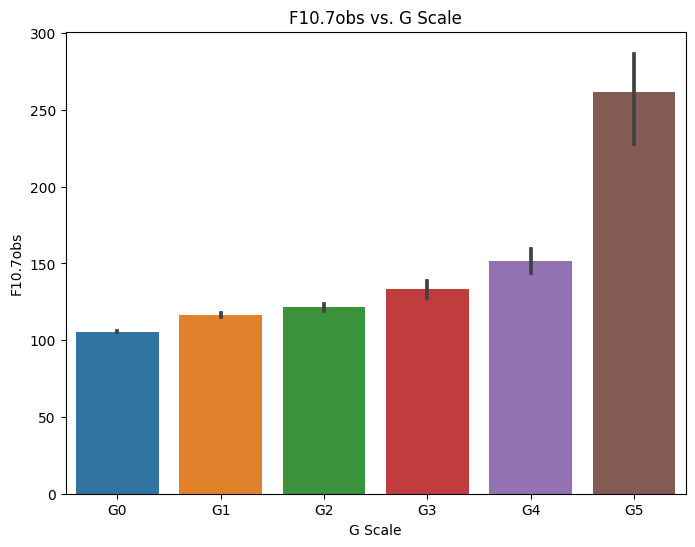

In [91]:
### The plot to illustrate the relation to the G scale with F.10.7obs
plt.figure(figsize=(8, 6))  

sns.barplot(data=df, y=ohe_df['F10.7obs'], x=ohe_df['G'])

plt.title('F10.7obs vs. G Scale')
plt.xlabel('G Scale')
plt.ylabel('F10.7obs')

plt.savefig("../images/F10.7obs_GScale_count.png")
plt.show()

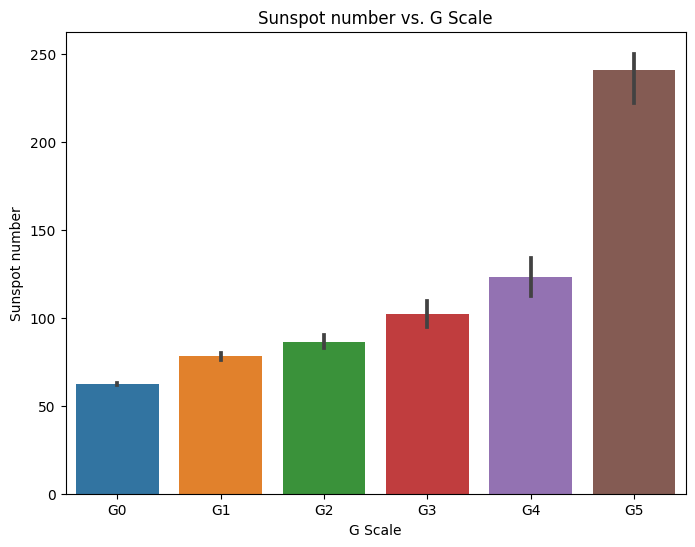

In [92]:
### The plot to illustrate the relation to the G scale with sunspot number
plt.figure(figsize=(8, 6))  

sns.barplot(data=df, y=ohe_df['SN'], x=ohe_df['G'])

plt.title('Sunspot number vs. G Scale')
plt.xlabel('G Scale')
plt.ylabel('Sunspot number')

plt.savefig("../images/sunspot_GScale_count.png")
plt.show()

In [93]:
ohe_df.index = sw.index

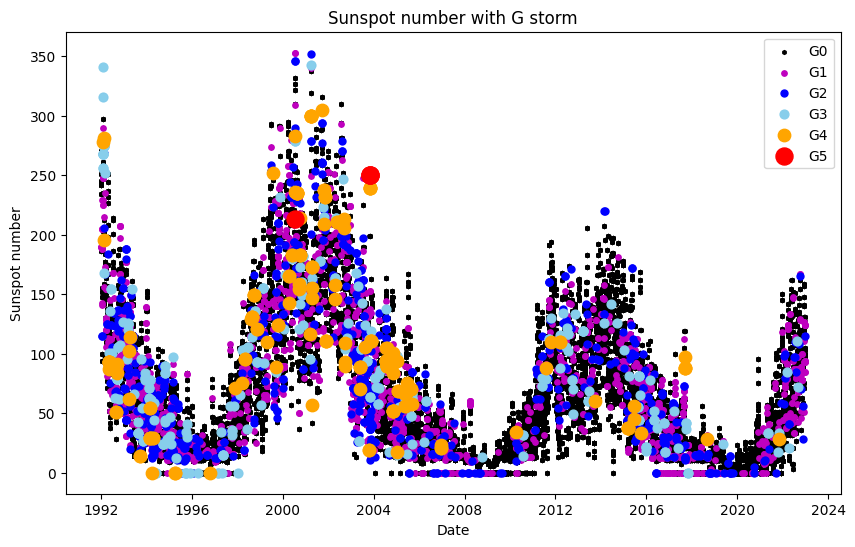

In [94]:
## Plot the figure
plt.figure(figsize=(10, 6))

# Filtering and plotting G scale 

g0_data = ohe_df[ohe_df['G'] == 'G0']
plt.scatter(g0_data.index, g0_data['SN'], label='G0', s=8, color = 'k', marker= 'h')

g1_data = ohe_df[ohe_df['G'] == 'G1']
plt.scatter(g1_data.index, g1_data['SN'], label='G1', s=15, color = 'm', marker= 'o')

g2_data = ohe_df[ohe_df['G'] == 'G2']
plt.scatter(g2_data.index, g2_data['SN'], label='G2', s=25, color = 'blue', marker= 'o')

g3_data = ohe_df[ohe_df['G'] == 'G3']
plt.scatter(g3_data.index, g3_data['SN'], label='G3', s=40, color = 'skyblue', marker= 'o')

g4_data = ohe_df[ohe_df['G'] == 'G4']
plt.scatter(g4_data.index, g4_data['SN'], label='G4', s=80, color = 'orange', marker= 'o')

g5_data = ohe_df[ohe_df['G'] == 'G5']
plt.scatter(g5_data.index, g5_data['SN'], label='G5', s=150, color = 'red', marker= 'o')


plt.xlabel('Date')
plt.ylabel('Sunspot number')
plt.title('Sunspot number with G storm')
plt.legend()

plt.savefig("../images/time_series_GScale_count.png")
plt.show()

### Model to predict G scale (Detecting the storm type)

#### Define the X,y variables

In [95]:
X = ohe_df.drop(columns = ['G'])
y = ohe_df['G']

In [96]:
X.columns = X.columns.str.lower()  ## lower case the training features

In [97]:
list(y.value_counts(normalize=False))

[84691, 3933, 1306, 405, 181, 4]

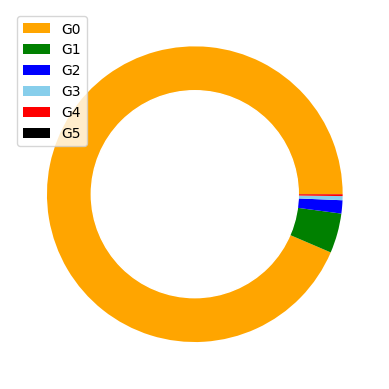

In [98]:
## Plot a pie chart/donut shape plot for the target varibale 
names = list(y.value_counts(normalize=True).index)
size = list(y.value_counts(normalize=True))
 
# Create a circle at the center of the plot
my_circle = plt.Circle( (0,0), 0.7, color='white')

# Give color names
pie = plt.pie(size, colors=['orange','green','blue','skyblue','red','k'])
p = plt.gcf()
p.gca().add_artist(my_circle)

# Adding legend based on names
plt.legend(pie[0], names, loc="best")

plt.savefig("../images/y_value_counts_G_scale.png")
# Show the graph
plt.show()

In [99]:
y.value_counts()

G
G0    84691
G1     3933
G2     1306
G3      405
G4      181
G5        4
Name: count, dtype: int64

### Noticed highly imbalanced target varibale

In [100]:
## Using SMOTE to overcome the issue
from imblearn.over_sampling import SMOTE

In [101]:
# Instantiate SMOTE 
smote = SMOTE(sampling_strategy='auto', k_neighbors=3, random_state=42)

# Apply SMOTE separately to the feature and target variables
X_resampled, y_resampled = smote.fit_resample(X, y)

In [102]:
### Train test split the data
X_train, X_test, y_train, y_test = train_test_split(X_resampled,y_resampled,test_size=0.25,stratify=y_resampled,random_state=2020) 

In [103]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [104]:
#### Function for model evaluation (train/test score)

In [105]:
def evaluation(name_of_the_model ,y_test,preds,gs_model):

    train_score = round(gs_model.score(X_train, y_train),3)
    test_score = round(gs_model.score(X_test,y_test),3)

    #Create a dataframe to compare the results
    df = pd.DataFrame(
        {'Model' :name_of_the_model,
        'Score on train':train_score ,
        'Score on test': test_score
        },index=[0]
    )

    return df #Display the dataframe

#### Instantiate RandomForestClassifier

In [106]:
rfc =  RandomForestClassifier(random_state=42)

In [107]:
#Define the grid of hyperparameters to search
params_rfc = {
    'n_estimators': [200],
    'max_depth': [None],
    'min_samples_split': [2,20],
    'min_samples_leaf': [1],
    'max_features': ['sqrt'],
    'ccp_alpha' : [0.0],
}

In [108]:
# Perform Grid Search with cross-validation
gs_rfc = GridSearchCV(rfc, params_rfc, cv=5, scoring='accuracy')

In [109]:
gs_rfc.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'ccp_alpha': [0.0], 'max_depth': [None],
                         'max_features': ['sqrt'], 'min_samples_leaf': [1],
                         'min_samples_split': [2, 20], 'n_estimators': [200]},
             scoring='accuracy')

In [110]:
gs_rfc.best_params_

{'ccp_alpha': 0.0,
 'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [111]:
preds_rfc = gs_rfc.predict(X_test)

In [112]:
Randomfc=evaluation('Randomfc',y_test,preds_rfc,gs_rfc)
Randomfc

,Model,Score on train,Score on test
0,Randomfc,0.982,0.951


#### Instantiate DecisionTreeClassifier

In [113]:
dt =  DecisionTreeClassifier()

In [114]:
params_dt = {      
    'max_depth': [None],      
    'min_samples_split': [10],        
    'min_samples_leaf': [0,1],#np.linspace(0,10,11,dtype = int),      
    'max_features': ['log2'],
    'ccp_alpha' : [0.0],
    'min_impurity_decrease' : [0]
}

In [115]:
# Perform Grid Search with cross-validation
gs_dt = GridSearchCV(dt, params_dt, cv=5, scoring='accuracy')

In [116]:
gs_dt.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'ccp_alpha': [0.0], 'max_depth': [None],
                         'max_features': ['log2'], 'min_impurity_decrease': [0],
                         'min_samples_leaf': [0, 1],
                         'min_samples_split': [10]},
             scoring='accuracy')

In [117]:
gs_dt.best_params_

{'ccp_alpha': 0.0,
 'max_depth': None,
 'max_features': 'log2',
 'min_impurity_decrease': 0,
 'min_samples_leaf': 1,
 'min_samples_split': 10}

In [118]:
preds_dt = gs_dt.predict(X_test)

In [119]:
DecisionTree=evaluation('DecisionTree',y_test,preds_dt,gs_dt)
DecisionTree

,Model,Score on train,Score on test
0,DecisionTree,0.967,0.933


##### Select the best model

In [120]:
Table = pd.concat([Randomfc,DecisionTree],ignore_index=True)

In [121]:
Table.set_index('Model')

,Score on train,Score on test
Model,,
Randomfc,0.982,0.951
DecisionTree,0.967,0.933


### Geomagnatic scale with the Kp index

| Kp    | Kp in decimals | G-scale | Auroral activity |
|-------|----------------|---------|------------------|
| 0o    | 0.00           | G0      | Quiet            |
| 0+    | 0.33           | G0      | Quiet            |
| 1-    | 0.67           | G0      | Quiet            |
| 1o    | 1.00           | G0      | Quiet            |
| 1+    | 1.33           | G0      | Quiet            |
| 2-    | 1.67           | G0      | Quiet            |
| 2o    | 2.00           | G0      | Quiet            |
| 2+    | 2.33           | G0      | Quiet            |
| 3-    | 2.67           | G0      | Unsettled        |
| 3o    | 3.00           | G0      | Unsettled        |
| 3+    | 3.33           | G0      | Unsettled        |
| 4-    | 3.67           | G0      | Active           |
| 4o    | 4.00           | G0      | Active           |
| 4+    | 4.33           | G0      | Active           |
| 5-    | 4.67           | G1      | Minor storm      |
| 5o    | 5.00           | G1      | Minor storm      |
| 5+    | 5.33           | G1      | Minor storm      |
| 6-    | 5.67           | G2      | Moderate storm   |
| 6o    | 6.00           | G2      | Moderate storm   |
| 6+    | 6.33           | G2      | Moderate storm   |
| 7-    | 6.67           | G3      | Strong storm     |
| 7o    | 7.00           | G3      | Strong storm     |
| 7+    | 7.33           | G3      | Strong storm     |
| 8-    | 7.67           | G4      | Severe storm     |
| 8o    | 8.00           | G4      | Severe storm     |
| 8+    | 8.33           | G4      | Severe storm     |
| 9-    | 8.67           | G4      | Severe storm     |
| 9o    | 9.00           | G5      | Extreme storm    |


### Display the predictions

In [131]:
pd.DataFrame(preds_rfc)[0].value_counts(normalize=True)

0
G4    0.168549
G3    0.168132
G5    0.166684
G2    0.165763
G1    0.165684
G0    0.165188
Name: proportion, dtype: float64

In [132]:
y_test.value_counts(normalize=True)

G
G1    0.166668
G3    0.166668
G0    0.166668
G2    0.166668
G5    0.166668
G4    0.166660
Name: proportion, dtype: float64

### Categorize the predictions to auroral activity

In [133]:
conditions = [
    preds_rfc == 'G0',
    preds_rfc == 'G1',
    preds_rfc == 'G2',
    preds_rfc == 'G3',
    preds_rfc == 'G4',
    preds_rfc == 'G5'
]

choices = [
    'Below storm level',
    'Minor storm',
    'Moderate storm',
    'Strong storm',
    'Severe storm',
    'Extreme storm'
]

auroral_activity= np.select(conditions, choices)

In [134]:
df = pd.DataFrame(list(auroral_activity))

In [150]:
df[0].value_counts(normalize=True)

0
Severe storm         0.168549
Strong storm         0.168132
Extreme storm        0.166684
Moderate storm       0.165763
Minor storm          0.165684
Below storm level    0.165188
Name: proportion, dtype: float64

### Model evaluation

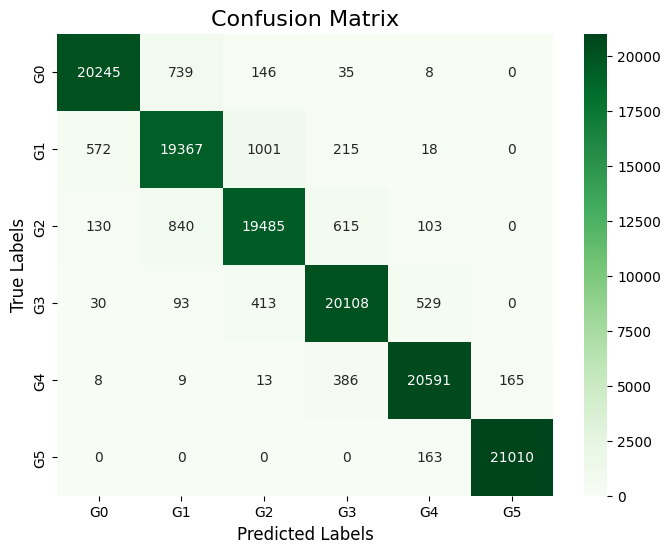

In [136]:
# Plot the confusion matrix as Seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, preds_rfc), annot=True, fmt='d',cmap = "Greens",
            xticklabels=["G0", "G1","G2","G3","G4","G5"],
            yticklabels=["G0", "G1","G2","G3","G4","G5"])
plt.xlabel("Predicted Labels",fontdict={'size':12})
plt.ylabel("True Labels",fontdict={'size':12})
plt.title("Confusion Matrix",fontdict={'size':16})
plt.savefig("../images/confusion_matrix.png")
plt.show()

In [137]:
print(classification_report(y_test, preds_rfc, digits=3))

              precision    recall  f1-score   support

          G0      0.965     0.956     0.960     21173
          G1      0.920     0.915     0.917     21173
          G2      0.925     0.920     0.923     21173
          G3      0.941     0.950     0.946     21173
          G4      0.962     0.973     0.967     21172
          G5      0.992     0.992     0.992     21173

    accuracy                          0.951    127037
   macro avg      0.951     0.951     0.951    127037
weighted avg      0.951     0.951     0.951    127037



#### Save the best model

In [138]:
import pickle

#### Make sure to download the model.pkl file to the below path and that file is not included on the github due to the size of the pkl file

In [144]:
###  Save the model
model = '../pickles/model.pkl'
pickle.dump(gs_rfc.best_estimator_, open(model, 'wb'))

In [145]:
### Load the saved model
loaded_model = pickle.load(open('../pickles/model.pkl', 'rb'))

# Predictions

### Testing data from 2023.01.01 - 2023.10.27

##### Below is the function created to predcit the G_storm

In [146]:
def predict_G_storm(omni, sunspot, phase):  ## here, the inputs are strings, insert the file for omni and sunspot, .csv file and mention the phase of the solar cycle 
    import pandas as pd
    import numpy as np
    import pickle
    import seaborn as sns
    from sklearn.preprocessing import OneHotEncoder
    from sklearn.compose import ColumnTransformer

    ### Load the model
    with open('../pickles/model.pkl', 'rb') as model_file:
        loaded_model = pickle.load(model_file)
    
    path = '../Data_collection/Data/' + omni

    new = pd.read_csv(path, skiprows=None)
    new.columns = ['date','B','T[K]','Np','Ur']

    new['date'] = pd.to_datetime(new['date'])
    new.set_index(new['date'],inplace = True)
    new_sw = new.drop(columns = ['date'])
    new_sw  = new_sw.resample('3H').mean()


    ### Categorize the wind speed into slow, and fast solar wind speed
    new_sw.loc[(new_sw['Ur'] > 200.0) & (new_sw['Ur'] < 450.0), 'Wind_Category'] = 'slow'
    new_sw.loc[(new_sw['Ur'] >=450) & (new_sw['Ur'] < 850.0), 'Wind_Category'] = 'fast'
    new_sw.loc[new_sw['Ur'] >= 850, 'Wind_Category'] = 'extreme'

    ### Categorize the plasma density at 1au
    new_sw.loc[(new_sw['Np'] >= 0.1) & (new_sw['Np'] < 7), 'Np_Category'] = 'low'
    new_sw.loc[(new_sw['Np'] >= 7) & (new_sw['Np'] < 60), 'Np_Category'] = 'high'
    new_sw.loc[new_sw['Np'] >= 60, 'Np_Category'] = 'extreme'

    ### Categorize the magnetic field at 1au
    new_sw.loc[(new_sw['B'] >= 0.1) & (new_sw['B'] < 6.3), 'B_Category'] = 'low'
    new_sw.loc[(new_sw['B'] >= 6.3) & (new_sw['B'] < 30), 'B_Category'] = 'high'
    new_sw.loc[new_sw['B'] >= 30, 'B_Category'] = 'extreme'

    ### Categorize the temperature at 1au
    new_sw.loc[(new_sw['T[K]'] >= 0) & (new_sw['T[K]'] < 110_000), 'T_Category'] = 'low'
    new_sw.loc[(new_sw['T[K]'] >= 110_000) & (new_sw['T[K]'] < 1_000_000), 'T_Category'] = 'high'
    new_sw.loc[new_sw['T[K]'] >= 1_000_000, 'T_Category'] = 'extreme'

    new_sw.drop(columns = ['B','T[K]','Np','Ur'],inplace = True)

    new_sw['phase'] = phase

    
    df3 = pd.read_csv('../Data_collection/Data/' + sunspot)

    new_sw['SN'] = np.repeat(np.array(df3['SN']), 8)
    new_sw['F10.7obs'] = np.repeat(np.array(df3['F10.7obs']), 8)

    # Columns to be One-Hot Encoded
    ohe_cols = ['Wind_Category','Np_Category','B_Category','T_Category','phase']
    
    # Columns to be passed without transformation
    passthrough = ['SN', 'F10.7obs']
    
    # Initializing the ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('ohe', OneHotEncoder(), ohe_cols),
            ('passthrough', 'passthrough', passthrough)
        ],
        remainder='drop'  # Drops the columns that are not specified
    )
    
    # Fit and transform the data
    transformed_data = preprocessor.fit_transform(new_sw)

    
    columns = list(preprocessor.named_transformers_['ohe'].get_feature_names_out()) + passthrough
    
    # Convert the transformed data back to a DataFrame
    test = pd.DataFrame(transformed_data, columns= columns)
    
    test.columns = test.columns.str.lower()
    
    train_columns = ['wind_category_extreme',
                     'wind_category_fast',
                     'wind_category_slow',
                     'np_category_extreme',
                     'np_category_high',
                     'np_category_low',
                     'b_category_extreme',
                     'b_category_high',
                     'b_category_low',
                     't_category_extreme',
                     't_category_high',
                     't_category_low',
                     'phase_declining',
                     'phase_rising',
                     'phase_solar_max',
                     'phase_solar_min',
                     'sn',
                     'f10.7obs']

    #The columns that should be added to the test data
    columns_test = [col for col in train_columns if col not in test.columns] 
    
    # Create a DataFrame with the new columns filled with zeros equaling the length of the dataframe that should be added to the test dataframe
    
    columns_test_df = pd.DataFrame({col: [0] * len(test) for col in columns_test})
    
    Test = pd.concat([test, columns_test_df], axis=1)
    
    new_sw['G'] = list(loaded_model.predict(Test[train_columns]))

    proba = list(loaded_model.predict_proba(Test[train_columns]))

    Test.index = new_sw.index

    probability = [row[0] for row in proba]

    new_sw['probability'] = np.round(probability,3)
    
    return new_sw.loc[:,'G':'probability']

In [147]:
predict_G_storm(omni = 'test.csv1',sunspot= 'test_sc.csv', phase = 'rising').head(10)

,G,probability
date,,
2023-01-01 00:00:00+00:00,G0,0.956
2023-01-01 03:00:00+00:00,G0,0.956
2023-01-01 06:00:00+00:00,G0,0.956
2023-01-01 09:00:00+00:00,G0,0.991
2023-01-01 12:00:00+00:00,G0,0.956
2023-01-01 15:00:00+00:00,G0,0.956
2023-01-01 18:00:00+00:00,G0,0.956
2023-01-01 21:00:00+00:00,G0,0.956
2023-01-02 00:00:00+00:00,G0,1.000


#### Save the predict_G_storm function

In [148]:
# Save the function 
with open('../pickles/predict_G_storm.pkl', 'wb') as file:
    pickle.dump(predict_G_storm, file)

### Author:
    
**Kalpa Henadhira Arachchige** 
    - [Github](https://github.com/kharindra)
    -[LinkedIn](https://www.linkedin.com/in/kalpa-henadhira/)
    

### Special Thanks
- To our advisors: Musfiqur Rahman, Sonyah Seiden, and Eric Bayless